In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize

sns.set(rc={'figure.figsize':(15,8)})

daily_total = pd.read_csv('daily-total-female-births-in-cal.csv')
international_airline = pd.read_csv('international-airline-passengers.csv')

Определим вспомогательные функции

In [2]:
def mse(y_true, y_pred):
  assert len(y_true) == len(y_pred), 'y_true и y_pred должны быть одинаковой длины'
  return (((y_true - y_pred) ** 2).sum() / len(y_true))

def mae(y_true, y_pred):
  assert len(y_true) == len(y_pred), 'y_true и y_pred должны быть одинаковой длины'
  return ((np.abs(y_true - y_pred)).sum() / len(y_true))

In [3]:
def ma(series, n=10):
  return series.rolling(n).mean()

In [4]:
def wma(series, weights=np.array([1 for _ in range(10)])):
  n = len(weights)
  return series.rolling(n).apply(lambda x: (x * weights).sum() / weights.sum())

#Стационарный ряд

([<matplotlib.axis.XTick at 0x7f25d2882920>,
 [Text(1, 0, '1959-01-02'),
  Text(76, 0, '1959-03-18'),
  Text(151, 0, '1959-06-01'),
  Text(226, 0, '1959-08-15'),
  Text(301, 0, '1959-10-29')])

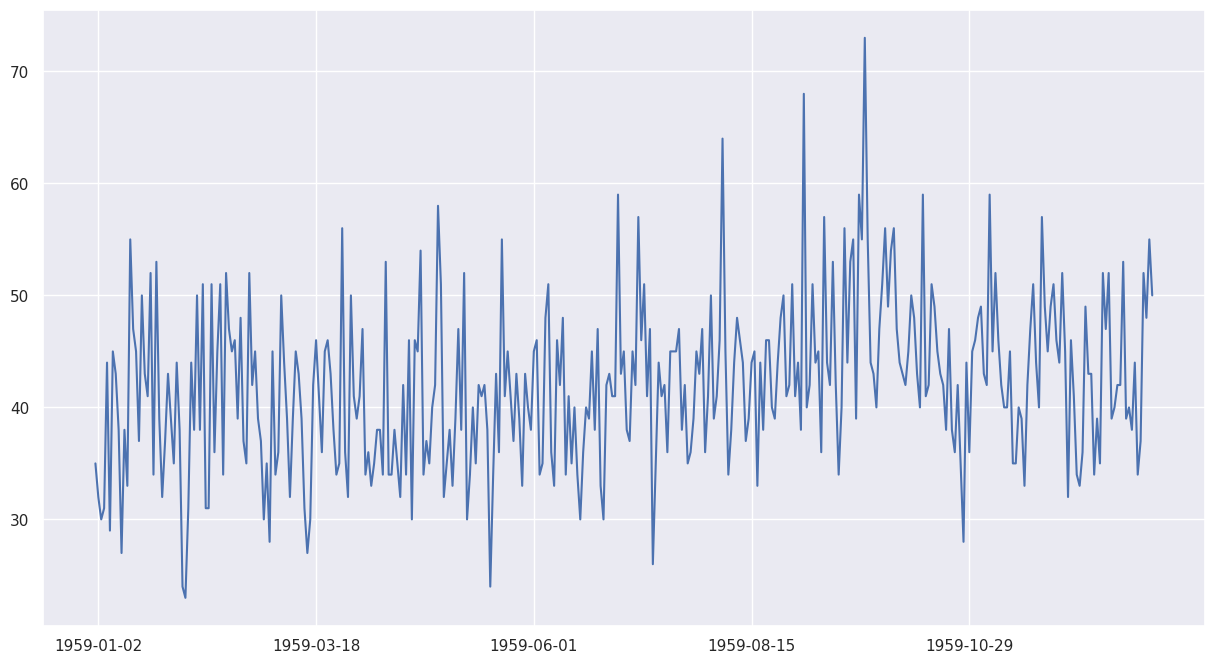

In [44]:
plt.plot(daily_total[daily_total.columns[0]], daily_total[daily_total.columns[1]])
plt.xticks(range(1, daily_total.shape[0], 75))

Так как данный ряд не имеет ни тренда, ни сезонности, следует использовать обычные скользящие средние (не DEMA и TEMA)

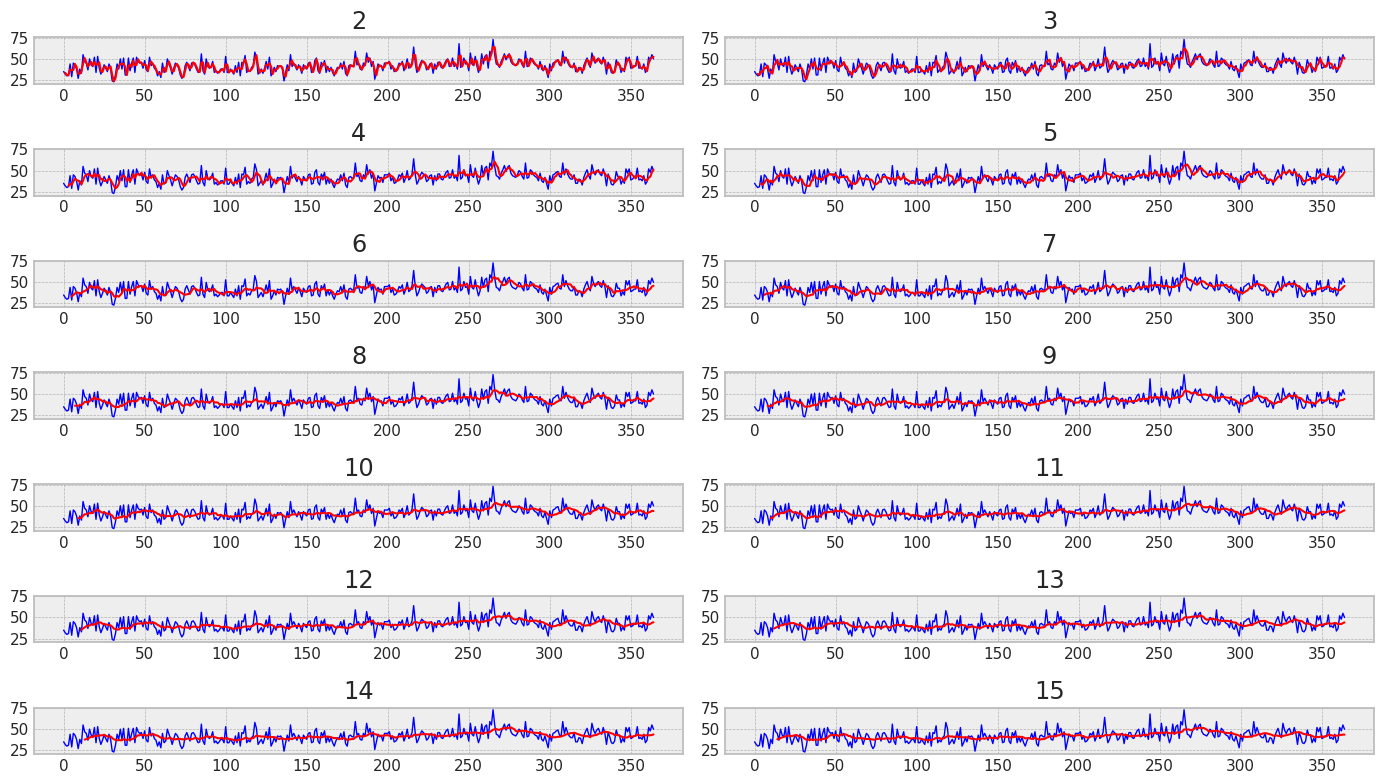

In [43]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    layout = (7, 2)
    for i, key in enumerate([j for j in range(2, 16)]):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        plt.plot(daily_total.iloc[:, 1], color='blue', linewidth='1')
        plt.plot(ma(daily_total.iloc[:, 1], int(key)), color='red', linewidth='1.5')
        ts_ax.set_title(key)

    plt.tight_layout()

MA 11 в одно время не сильно сглаживает ряд, как более старшие MA, и позволяет видеть общее направление временного ряда

In [113]:
print(f'MSE: {mse(ma(daily_total.iloc[:, 1], 11)[10:], daily_total.iloc[:, 1][10:])}')

MSE: 43.46544057734839


#Нестационарный ряд

([<matplotlib.axis.XTick at 0x7f25d2763fd0>,
 [Text(1, 0, '1949-02'), Text(76, 0, '1955-05')])

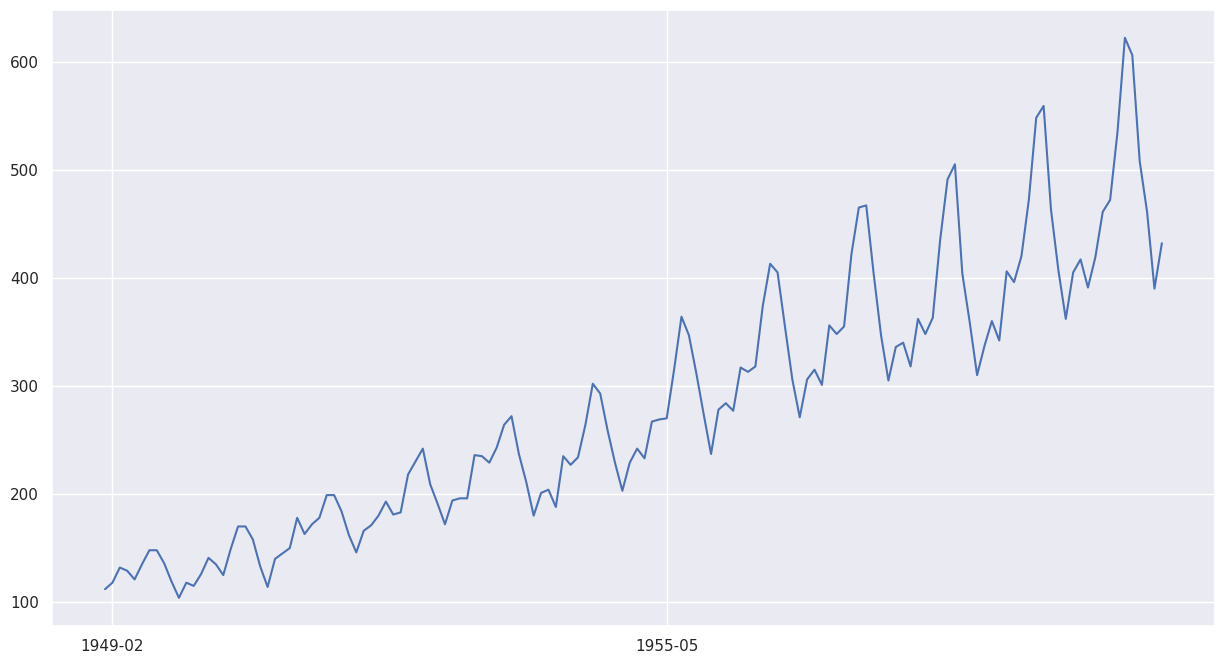

In [45]:
plt.plot(international_airline[international_airline.columns[0]], international_airline[international_airline.columns[1]])
plt.xticks(range(1, international_airline.shape[0], 75))

Так как ряд нестационарный, имеет тренд и сезонность, необходимо использовать TEMA, так как DEMА работает хорошо только при условии отсутствия сезонности

In [100]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [59]:
series = international_airline.iloc[:, 1]

In [92]:
train, test, val = series[:100], series[100:110], series[110:]

In [93]:
def tema_mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mse(predictions, test)
    return error

In [94]:
opt = minimize(tema_mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [99]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1101.1630818204553
        x: [ 9.966e-01  8.520e-03  9.993e-01]
      nit: 16
      jac: [-5.648e-02  7.551e-02  2.565e-01]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


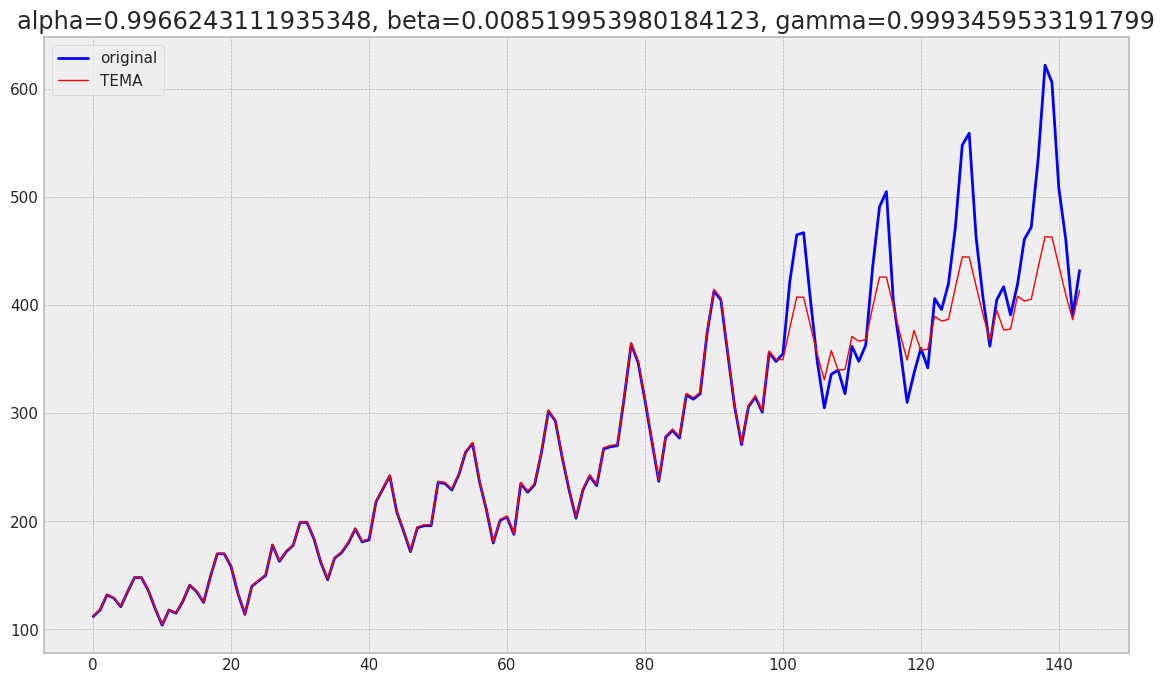

In [98]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:100], ser_to_plot=series, n_preds=len(val) + len(test))

Скорее всего, из-за монотонно возрастающей дисперсии ряда, генерализующей способности TEMA не хватает для более успешного предсказания ряда, попробуем убрать монотонно возрастающую дисперсию и повторить те же действия

In [101]:
series = np.log(international_airline.iloc[:, 1])

In [102]:
train, test, val = series[:100], series[100:110], series[110:]

In [104]:
opt = minimize(tema_mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [105]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.00163639072696535
        x: [ 9.584e-01  3.488e-03  1.000e+00]
      nit: 16
      jac: [-2.524e-07  9.436e-07 -2.825e-05]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


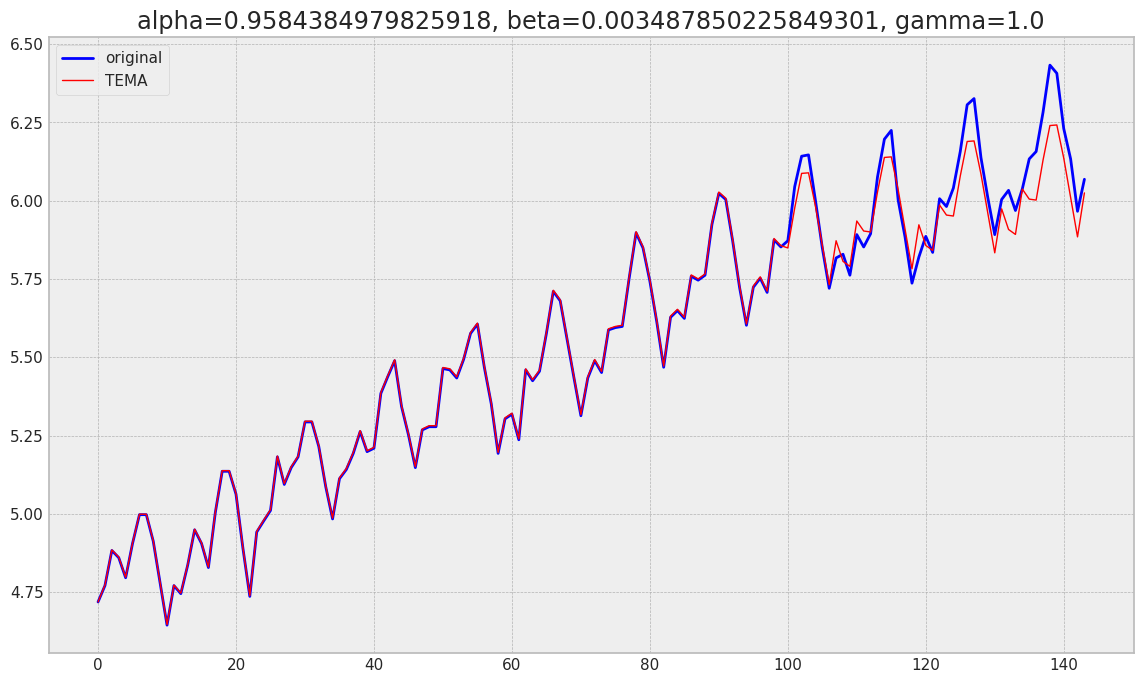

In [106]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:100], ser_to_plot=series, n_preds=len(val) + len(test))

Результат стал лучше. Делаем вывод, что TEMA работает намного хуже, если дисперсия ряда монотонно возрастает или убывает

In [116]:
print(f'MSE: {tema_mse(opt.x)}')

MSE: 0.00163639072696535
